# Network, Graph and Graph Database

## Prepare the dataset

In [1]:
# https://zenodo.org/record/4670228

TEST_DATA_FOLDER = "test_data/flights"

!mkdir -p $TEST_DATA_FOLDER

# Uncomment the dataset to download
#!curl https://zenodo.org/record/4670228/files/flightlist_20191201_20191231.csv.gz -o {TEST_DATA_FOLDER}/flightlist_20191201_20191231.csv.gz
#!curl https://zenodo.org/record/4670228/files/flightlist_20210301_20210331.csv.gz -o {TEST_DATA_FOLDER}/flightlist_20210301_20210331.csv.gz 
!curl https://zenodo.org/record/4670228/files/flightlist_20201201_20201231.csv.gz -o {TEST_DATA_FOLDER}/flightlist_20201201_20201231.csv.gz

#!gunzip {TEST_DATA_FOLDER}/flightlist_20191201_20191231.csv.gz
#!gunzip {TEST_DATA_FOLDER}/flightlist_20210301_20210331.csv.gz 
!gunzip {TEST_DATA_FOLDER}/flightlist_20201201_20201231.csv.gz 

!ls -lh {TEST_DATA_FOLDER}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  126M  100  126M    0     0  2963k      0  0:00:43  0:00:43 --:--:-- 2579k  103M    0     0  3128k      0  0:00:41  0:00:33  0:00:08 2124k
total 2649216
-rw-r--r--  1 mengwangk  staff   515M May  2 12:11 flightlist_20191201_20191231.csv
-rw-r--r--  1 mengwangk  staff   361M May  2 22:09 flightlist_20201201_20201231.csv
-rw-r--r--  1 mengwangk  staff   394M May  2 12:12 flightlist_20210301_20210331.csv


## Data Cleansing

In [2]:
# Uncomment to install the dependency
# Refer below for more details
# - https://scitools.org.uk/cartopy/docs/latest/installing.html#installing
# - https://networkx.org/documentation/latest/install.html

# References for maps
# - https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
# - https://semba-blog.netlify.app/07/04/2020/mapping-with-cartopy-in-python/
# - https://ipython-books.github.io/142-drawing-flight-routes-with-networkx/

# !conda install -c conda-forge cartopy networkx -y

In [3]:
import math
import json
import numpy as np
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [25]:
FLIGHT_DEC_2019 = f"{TEST_DATA_FOLDER}/flightlist_20191201_20191231.csv"
FLIGHT_DEC_2020 = f"{TEST_DATA_FOLDER}/flightlist_20201201_20201231.csv"
FLIGHT_MAR_2021 = f"{TEST_DATA_FOLDER}/flightlist_20210301_20210331.csv"

In [46]:
#df = pd.read_csv(FLIGHT_DEC_2019, low_memory=False)
df = pd.read_csv(FLIGHT_MAR_2021, low_memory=False)
#df = pd.read_csv(FLIGHT_DEC_2020, low_memory=False)
len(df)

2079436

In [47]:
df.head(10)

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2
0,HBAL317,NaN,a2a168,NaN,NaN,NaN,NaN,2021-02-28 00:00:14+00:00,2021-03-01 04:42:43+00:00,2021-03-01 00:00:00+00:00,-1.150131,36.943623,17068.8,0.423765,37.845249,18318.48
1,THY057,NaN,4ba953,TC-JJS,B77W,LTFM,LTFM,2021-02-28 00:00:35+00:00,2021-03-01 01:42:28+00:00,2021-03-01 00:00:00+00:00,41.377863,28.708461,914.4,41.198777,28.728998,373.38
2,FDX9163,FX9163,a810af,N619FE,MD11,NaN,WSSS,2021-02-28 00:13:45+00:00,2021-03-01 17:29:37+00:00,2021-03-01 00:00:00+00:00,34.992279,-90.370620,3657.6,1.296799,103.955383,342.90
3,AZV2059,NaN,42429f,VP-BUY,B763,NaN,EGLL,2021-02-28 00:41:36+00:00,2021-03-01 06:40:26+00:00,2021-03-01 00:00:00+00:00,56.331606,144.289198,10972.8,51.464859,-0.463801,-129.54
4,HBAL319,NaN,a24afc,NaN,NaN,NaN,NaN,2021-02-28 01:02:42+00:00,2021-03-01 04:42:43+00:00,2021-03-01 00:00:00+00:00,-0.569733,35.663111,16764.0,-0.995773,37.836216,18348.96
5,AMX014,NaN,0d09d0,XA-ADL,B789,NaN,SBGR,2021-02-28 01:59:16+00:00,2021-03-01 11:16:26+00:00,2021-03-01 00:00:00+00:00,-32.412598,-63.630011,10363.2,-23.442776,-46.501567,800.10
6,NOS907,NaN,4ca8fa,NaN,NaN,LIMC,LIMC,2021-02-28 02:50:10+00:00,2021-03-01 07:11:00+00:00,2021-03-01 00:00:00+00:00,45.635239,8.721537,0.0,45.623567,8.735298,60.96
7,ETH702,NaN,040087,ET-ARE,B788,KJFK,LIRF,2021-02-28 03:01:20+00:00,2021-03-01 02:34:59+00:00,2021-03-01 00:00:00+00:00,40.647273,-73.813768,0.0,41.853836,12.258183,-53.34
8,HBAL302,NaN,a16317,NaN,NaN,NaN,NaN,2021-02-28 04:21:18+00:00,2021-03-01 04:42:43+00:00,2021-03-01 00:00:00+00:00,0.633669,36.723507,17983.2,-1.278488,38.103612,18318.48
9,CKS416,NaN,a97282,N708CK,NaN,KSUU,RKSG,2021-02-28 07:14:04+00:00,2021-03-01 01:55:58+00:00,2021-03-01 00:00:00+00:00,38.315277,-121.875019,609.6,36.968216,126.974312,1219.20


In [48]:
df.columns

Index(['callsign', 'number', 'icao24', 'registration', 'typecode', 'origin',
       'destination', 'firstseen', 'lastseen', 'day', 'latitude_1',
       'longitude_1', 'altitude_1', 'latitude_2', 'longitude_2', 'altitude_2'],
      dtype='object')

In [49]:
df.dropna(subset = ["origin", "destination"], inplace=True)
len(df)

1315790

In [50]:
df[['altitude_1', 'altitude_2']] = df[['altitude_1','altitude_2']].fillna(value=0)

In [51]:
df = df[["origin", "destination", "day", "latitude_1", "longitude_1", "altitude_1", "latitude_2", "longitude_2", "altitude_2"]]
df.head(10)

,origin,destination,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2
1,LTFM,LTFM,2021-03-01 00:00:00+00:00,41.377863,28.708461,914.4,41.198777,28.728998,373.38
6,LIMC,LIMC,2021-03-01 00:00:00+00:00,45.635239,8.721537,0.0,45.623567,8.735298,60.96
7,KJFK,LIRF,2021-03-01 00:00:00+00:00,40.647273,-73.813768,0.0,41.853836,12.258183,-53.34
9,KSUU,RKSG,2021-03-01 00:00:00+00:00,38.315277,-121.875019,609.6,36.968216,126.974312,1219.20
10,WSSS,LIMC,2021-03-01 00:00:00+00:00,1.346244,103.976125,304.8,45.625010,8.734955,53.34
14,KJFK,KJFK,2021-03-01 00:00:00+00:00,40.647583,-73.814758,0.0,40.618178,-73.776002,99.06
16,VHHH,YSSY,2021-03-01 00:00:00+00:00,22.302293,113.916829,0.0,-33.993805,151.188242,266.70
18,KLAX,YSSY,2021-03-01 00:00:00+00:00,33.939561,-118.383121,0.0,-33.985886,151.186281,182.88
20,LFPO,LFPO,2021-03-01 00:00:00+00:00,48.721293,2.368710,-304.8,48.725622,2.332860,-60.96
21,UUEE,VHHH,2021-03-01 00:00:00+00:00,55.980103,37.457553,304.8,22.300095,113.909995,-30.48


## Network Visualization

In [52]:
edges = df[['origin', 'destination']].values
len(edges), edges

(1315790,
 array([['LTFM', 'LTFM'],
        ['LIMC', 'LIMC'],
        ['KJFK', 'LIRF'],
        ...,
        ['KHMT', 'KF70'],
        ['KMGY', 'KDAY'],
        ['KSNA', 'KLGB']], dtype=object))

In [53]:
g = nx.from_edgelist(edges)

In [54]:
len(g.nodes()), len(g.edges())

(12231, 165636)

In [55]:
#fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#nx.draw_networkx(g, ax=ax, node_size=5,
#                 font_size=6, alpha=.5,
#                 width=.5)
#ax.set_axis_off()

In [56]:
sg = next(g.subgraph(c) for c in nx.connected_components(g))

In [57]:
#fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#nx.draw_networkx(sg, ax=ax, with_labels=False,
#                  node_size=5, width=.5)
#ax.set_axis_off()

In [58]:
# Airport with latitude and longitude

airports = {}
altitudes = {}

for index, row in df.iterrows():
    if not row['origin'] in airports:
        airports[row['origin']] = (row['longitude_1'], row['latitude_1'])
        altitudes[row['origin']] = row['altitude_1']
    if not row['destination'] in airports:
        airports[row['destination']] = (row['longitude_2'], row['latitude_2'])
        altitudes[row['destination']] = row['altitude_2']
             

In [59]:
len(airports), len(altitudes)

(12231, 12231)

In [60]:
deg = nx.degree(sg)
sizes = [5 * deg[code] for code in sg.nodes]

In [61]:
altitudes = [altitudes[code] for code in sg.nodes]

In [62]:
len(altitudes)

12181

In [63]:
labels = {code: code if deg[code] >= 20 else '' for code in sg.nodes}

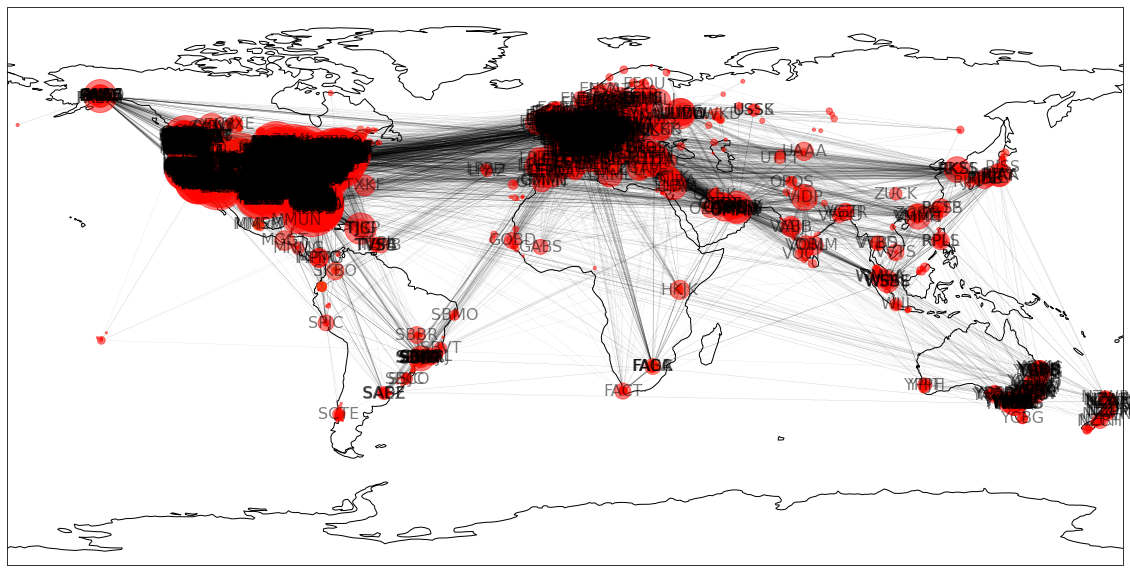

In [64]:
# Map projection
crs = ccrs.PlateCarree(central_longitude=0)
fig, ax = plt.subplots(
    1, 1, figsize=(20, 14),
    subplot_kw=dict(projection=crs))
ax.coastlines()
ax.set_global()
nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 alpha=.5,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=airports,
                 node_color=altitudes,
                 cmap=plt.cm.autumn)

In [65]:
sorted(g.degree, key=lambda x: x[1], reverse=True)

[('KCLT', 918),
 ('KAPF', 814),
 ('KORD', 774),
 ('KTEB', 773),
 ('KDFW', 772),
 ('KIAD', 757),
 ('KPDK', 757),
 ('KDAL', 754),
 ('KIND', 722),
 ('KATL', 718),
 ('KAPA', 714),
 ('KHPN', 701),
 ('KADS', 686),
 ('KSRQ', 666),
 ('KBNA', 658),
 ('KPWK', 653),
 ('KSDL', 644),
 ('KPHL', 630),
 ('KRDU', 620),
 ('KFMY', 614),
 ('KPTK', 598),
 ('KOPF', 597),
 ('KMDW', 595),
 ('KAUS', 593),
 ('KBWI', 587),
 ('KFLL', 584),
 ('KFXE', 566),
 ('KTYS', 564),
 ('KBED', 561),
 ('KORL', 560),
 ('KSUS', 553),
 ('KPBI', 535),
 ('KFTW', 533),
 ('KMIA', 531),
 ('KLAS', 529),
 ('KCMH', 528),
 ('KSDF', 525),
 ('KMCO', 515),
 ('KMKC', 512),
 ('KPHX', 509),
 ('KTUL', 508),
 ('KSAT', 508),
 ('KMSP', 502),
 ('KLUK', 499),
 ('KCLW', 483),
 ('KECP', 479),
 ('KSLC', 470),
 ('KDTW', 463),
 ('KHOU', 463),
 ('KDEN', 457),
 ('KMMU', 456),
 ('KDPA', 454),
 ('KDTS', 451),
 ('KHEF', 450),
 ('KOMA', 443),
 ('KVNY', 439),
 ('KLAX', 438),
 ('KBCT', 434),
 ('KOSU', 434),
 ('KBOS', 427),
 ('KPGD', 425),
 ('KBJC', 424),
 ('KRYY'